##### 1. 로이터 뉴스 데이터에 대한 이해

In [1]:
from tensorflow.keras.datasets import reuters
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [3]:
print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


##### 뉴스 기사의 길이 파악

뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


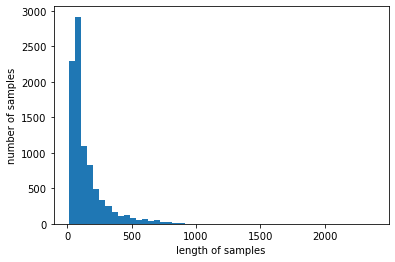

In [4]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

##### 뉴스 category 분포 시각화

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


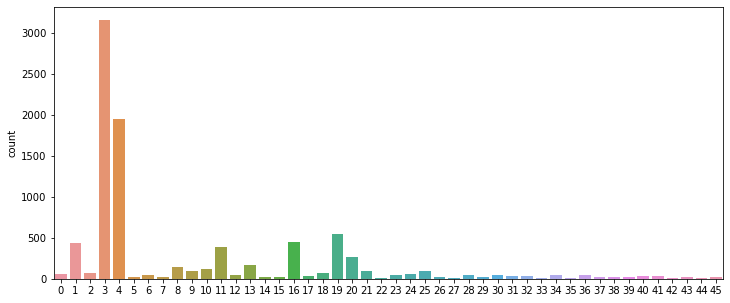

In [5]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)
plt.show()

In [6]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [7]:
word_to_index = reuters.get_word_index()
print(list(word_to_index.items())[:20])

[('mdbl', 10996), ('fawc', 16260), ('degussa', 12089), ('woods', 8803), ('hanging', 13796), ('localized', 20672), ('sation', 20673), ('chanthaburi', 20675), ('refunding', 10997), ('hermann', 8804), ('passsengers', 20676), ('stipulate', 20677), ('heublein', 8352), ('screaming', 20713), ('tcby', 16261), ('four', 185), ('grains', 1642), ('broiler', 20680), ('wooden', 12090), ('wednesday', 1220)]


##### 출현빈도 상위 index 추출 용이하도록 아래와 같은 Dictionary 생성

In [8]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [9]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 2번 단어 : {}'.format(index_to_word[2]))
print('빈도수 상위 3번 단어 : {}'.format(index_to_word[3]))
print('빈도수 상위 100번 단어 : {}'.format(index_to_word[100]))
print('빈도수 상위 28842번 단어 : {}'.format(index_to_word[28842]))

빈도수 상위 1번 단어 : the
빈도수 상위 2번 단어 : of
빈도수 상위 3번 단어 : to
빈도수 상위 100번 단어 : group
빈도수 상위 28842번 단어 : nondiscriminatory


In [10]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs


# 2. LSTM으로 로이터 뉴스 분류하기

In [11]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [12]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM , Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [13]:
#빈도수 상위 1000개만 사용
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

In [14]:
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 뉴스 기사 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 뉴스 기사 패딩

##### Train과 test 뉴스길이 다름 => pad_sequences를 사용하여 100개로 맞춰줌

In [15]:
print(X_train.shape, X_test.shape)

(8982, 100) (2246, 100)


##### 기사 데이터의 레이블에 원-핫 인코딩

In [16]:
y_train = to_categorical(y_train) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 뉴스 기사 레이블의 원-핫 인코딩

In [32]:
model = Sequential()
model.add(Embedding(2000, 120))
model.add(LSTM(120))
model.add(Dense(46, activation='softmax'))

#120 차원을 가지는 임베딩 벡터를1000개 생성?

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [35]:
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Train on 8982 samples, validate on 2246 samples
Epoch 1/30
8576/8982 [===========================>..] - ETA: 0s - loss: 2.6248 - acc: 0.3460
Epoch 00001: val_acc improved from -inf to 0.36198, saving model to best_model.h5
8982/8982 [==============================] - 3s 283us/sample - loss: 2.6141 - acc: 0.3470 - val_loss: 2.3640 - val_acc: 0.3620
Epoch 2/30
8448/8982 [===========================>..] - ETA: 0s - loss: 2.1643 - acc: 0.4435
Epoch 00002: val_acc improved from 0.36198 to 0.49332, saving model to best_model.h5
8982/8982 [==============================] - 1s 106us/sample - loss: 2.1614 - acc: 0.4439 - val_loss: 2.0038 - val_acc: 0.4933
Epoch 3/30
8448/8982 [===========================>..] - ETA: 0s - loss: 1.8936 - acc: 0.5079
Epoch 00003: val_acc improved from 0.49332 to 0.53606, saving model to best_model.h5
8982/8982 [==============================] - 1s 108us/sample - loss: 1.8953 - acc: 0.5071 - val_loss: 1.7934 - val_acc: 0.5361
Epoch 4/30
8448/8982 [==================

##### 이유는 도저히 못찾앗지만 , early stopping을 통해 저장한 모델을 load 과정에서 막힘
- 오류명 없이 oserror만 발생함 => 구글링했는데 유사한 에러 경우가 거의없음

In [36]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

OSError: 

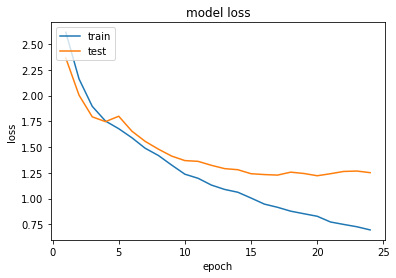

In [37]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
print('정확도 : ' , model.history.history['val_acc'][-1])

정확도 :  0.71104187
